### 삼성전자 시세 인공지능으로 예측해보자 - Python, Deep Learning (LSTM)

#### LSTM( Long Short Term Memory)
- 인공지능 모델이 기억을 가지고 있다는 뜻을 가지고 있다. 
- 이전 데이터를 가지고 이후의 데이터를 예측하는 인공지능 모델
- 인공지능이 기억력을 가지고 예측할 수 있다는 것이 LSTM의 장점
- 주식, 암호화폐 등으로 많이 사용

## 5년치 데이터를 가지고 예측 하기 

##### 라이브러리

In [155]:
import pandas as pd # csv 파일 로드
import numpy as np # 행렬 연산
import matplotlib.pyplot as plt # 데이터 시각화
from tensorflow.keras.models import Sequential # 딥러닝 모델 작성 
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation 
import datetime 


##### Load DAtaset

In [156]:
data = pd.read_csv("samsung.csv", encoding='cp949')
data.head() 

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-31,21420.0,21780.0,21040.0,21780.0,219.815475,20415450.0
1,2015-09-01,21780.0,21960.0,21620.0,21700.0,219.008072,12018600.0
2,2015-09-02,21380.0,21900.0,21300.0,21800.0,220.017349,15634150.0
3,2015-09-03,22040.0,22500.0,21860.0,22440.0,226.476532,15200350.0
4,2015-09-04,22440.0,22880.0,22360.0,22580.0,227.889496,12570650.0


##### Compute MId Price

In [157]:
high_price = data['High'].values
low_price = data['Low'].values
mid_price = (high_price+low_price)/2 # 중간값 생성 
mid_price

array([21410., 21790., 21600., ..., 56100., 55950., 55850.])

##### Create Windows
- 50(Windows) 일간의 데이터를 보고 내일 값을 예측 

In [158]:
seq_len = 50 # window siwze - 변경이 가능 
sequence_length = seq_len + 1 # window 값 + 예측값 1 (총51게)


# 반복문을 만들어서 51개씩 넣어주도록 만듬
result = []
for index in range(len(mid_price) - sequence_length):
    result.append(mid_price[index: index + sequence_length])    
result

[array([21410., 21790., 21600., 22180., 22620., 22340., 22420., 22830.,
        22570., 22480., 22340., 22410., 22780., 23010., 23270., 23230.,
        22800., 22690., 22600., 22340., 22240., 22660., 22450., 22460.,
        22820., 24380., 25290., 25100., 25200., 24970., 25250., 25280.,
        25140., 25290., 25410., 25640., 25780., 25700., 25800., 25990.,
        27160., 27310., 27670., 27310., 26870., 26840., 26780., 26650.,
        26550., 26660., 26510.]),
 array([21790., 21600., 22180., 22620., 22340., 22420., 22830., 22570.,
        22480., 22340., 22410., 22780., 23010., 23270., 23230., 22800.,
        22690., 22600., 22340., 22240., 22660., 22450., 22460., 22820.,
        24380., 25290., 25100., 25200., 24970., 25250., 25280., 25140.,
        25290., 25410., 25640., 25780., 25700., 25800., 25990., 27160.,
        27310., 27670., 27310., 26870., 26840., 26780., 26650., 26550.,
        26660., 26510., 26170.]),
 array([21600., 22180., 22620., 22340., 22420., 22830., 22570., 2248

##### Normalize Date (정규화) - 모델의 예측을 도움

In [159]:
normalized_data = []

# window 를 돌면서 첫번째 값으로 나눈 후 -1 해준 값

for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1)for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data) 
result

array([[ 0.        ,  0.01774872,  0.00887436, ...,  0.24007473,
         0.24521252,  0.23820645],
       [ 0.        , -0.0087196 ,  0.01789812, ...,  0.22349702,
         0.21661313,  0.20100964],
       [ 0.        ,  0.02685185,  0.04722222, ...,  0.22731481,
         0.21157407,  0.18240741],
       ...,
       [ 0.        ,  0.00785083,  0.02257115, ...,  0.10598626,
         0.09911678,  0.10794897],
       [ 0.        ,  0.01460565,  0.01168452, ...,  0.09055501,
         0.0993184 ,  0.09250243],
       [ 0.        , -0.00287908,  0.00287908, ...,  0.08349328,
         0.07677543,  0.07389635]])

##### split train and test data
- train set 안에 test set을 무조건 넣으면 안됨. 검증이 불가해짐
- train set 은 랜덤으로 썩어줌(np.random.shuffle())

In [160]:
row = int(round(result.shape[0]*0.9))
train = result[:row, :]
np.random.shuffle(train) 

# x_train - 50개, y_train - 1개 
x_train = train[:,:-1] # 50개
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
y_train = train[:,-1] # 1개



x_test = result[row:,:-1] 
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
y_test = result[row:, -1]

# x_train.shape,x_test.shape # 1058일의 데이터를 가지고 117일을 예측

##### Bulid a Model 
- 모델에 레이러드 추가 model.add()
- Fully connected layer : kreas.layers.Dense() - 예측하고자 하는 값 
- 손실함수 : MSE(Mean Squared Error) 사용
- optimizer : rmsprop 사용
- 모델의 개요 출력 : model.summary()


In [161]:
model=Sequential()

model.add(LSTM(50, return_sequences = True, input_shape = (50,1))) # input = 50개 

model.add(LSTM(64, return_sequences = False))  

model.add(Dense(1, activation='linear')) # output = 1개 

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 50, 50)            10400     
_________________________________________________________________
lstm_23 (LSTM)               (None, 64)                29440     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


##### Training 
- 모델 학습 : model.fit()
- bathc_size : 한번에 학습시킬 개수
- epochs : 반복 횟수

In [166]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=10,epochs=20)

Epoch 1/20
106/106 [==============================] - 2s 17ms/step - loss: nan - val_loss: nan
Epoch 2/20
106/106 [==============================] - 2s 19ms/step - loss: nan - val_loss: nan
Epoch 3/20
106/106 [==============================] - 2s 20ms/step - loss: nan - val_loss: nan
Epoch 4/20
 52/106 [=============>................] - ETA: 1s - loss: nan

KeyboardInterrupt: 

##### Prediction

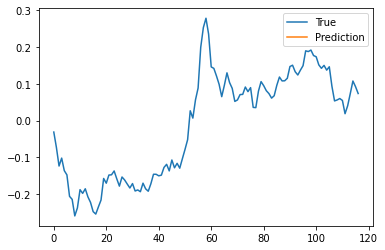

In [163]:
pred = model.predict(x_test)

fig = plt.figure(facecolor = 'white')
ax = fig.add_subplot(111)
ax.plot(y_test,label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()